## Check phenology changes over specific regions

Focusing on any interesting regions. e.g Forests, the MDB, landcover types

In [1]:
import sys
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

import odc.geo.xr
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

In [2]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'
var='NDVI'
ds_path = base+'NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path)[var], crs='EPSG:4326')

trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

trees_mask = xr.where(trees>0.25, 1, 0)
non_trees_mask = xr.where(trees<=0.25, 1, 0)

## Smooth datasets

In [4]:
ds = ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay
ds = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='allowed'
    )
#SG cuts of last 6 months so clip to complete calendar years.
ds = ds.sel(time=slice('1982', '2021'))

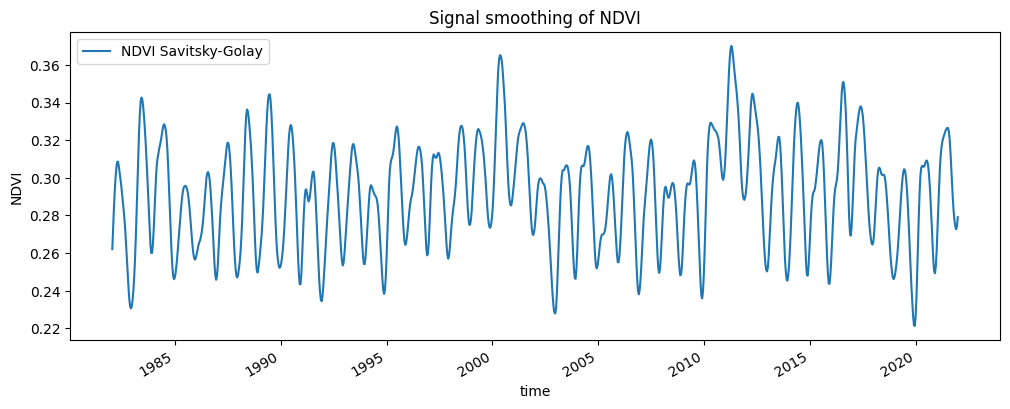

In [5]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
ds.mean(['latitude', 'longitude']).plot(ax=ax, label='NDVI Savitsky-Golay')
ax.legend(loc='upper left')
ax.set_title('Signal smoothing of NDVI');

## Phenology stats

In [6]:
warnings.simplefilter('ignore')
pheno = ds.groupby('time.year').map(xr_phenology)

## Some forested regions

Tropics, WA, Tasmania, SE Aus.

In [7]:
#limit regions to tropical forests ~north of Townsville
lat_tf = slice(0, -19.3)
lon_tf = slice(142,147.5)
n_tf = 'N. QLD. Tropical Forest'

#tassie forest
lat_tas = slice(-40, -45)
lon_tas = slice(144,149)
n_tas = 'Tasmanian Forest'

# SW WA forest
lat_WA=slice(-31,-36) 
lon_WA=slice(114.5,119)
n_WA = 'Southwest WA Forest'

# SE Aus Forest
lat_SEA=slice(-32.5,-39.2) 
lon_SEA=slice(145,152)
n_SEA = 'Southeast NSW/Vic Forest'

# ds_WA = ds.sel(x=lon, y=lat)

In [8]:
ds_trees = ds.where(trees_mask)
ds_nontrees = ds.where(non_trees_mask)

ds_SEA = ds_trees.sel(longitude=lon_SEA, latitude=lat_SEA)
ds_WA = ds_trees.sel(longitude=lon_WA, latitude=lat_WA)
ds_tas = ds_trees.sel(longitude=lon_tas, latitude=lat_tas)
ds_tf = ds_trees.sel(longitude=lon_tf, latitude=lat_tf)

### Interpolate phenology onto grid

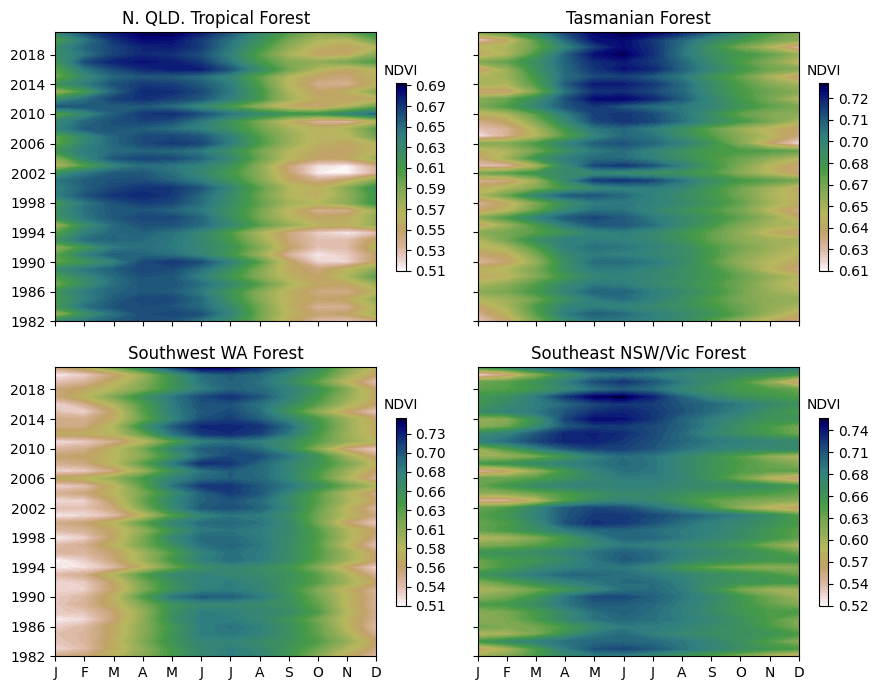

In [9]:
#create a grid
xi = np.linspace(1, 12, 12) #months
yi = np.linspace(1982, 2021, 40) #years
Xi, Yi = np.meshgrid(xi, yi) #grid coords

ds_dict = {n_tf:ds_tf, n_tas:ds_tas, n_WA:ds_WA, n_SEA:ds_SEA}

plt.style.use('default')
fig, axes = plt.subplots(2,2, figsize=(9,7), sharex=True, sharey=True)
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    dss = v.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    zi = griddata(points=(dss.time.dt.month, dss.time.dt.year),
                  values=dss.mean(['latitude','longitude']).values,
                  xi=(xi[None, :], yi[:, None]),
                  method='nearest')
    
    sp = ax.contourf(zi, levels=75, cmap='gist_earth_r')
    clb = plt.colorbar(sp, ax=ax, shrink=0.65, format="%0.2f")
    clb.ax.set_title('NDVI', fontsize=10)
    
    ax.set(xticks=range(0,12))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
    ax.set(yticks=range(0,40))
    ax.set_yticklabels([str(y) for y in range(1982,2022)], fontsize=10);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
    ax.set_title(k);
plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/phenology_grids_forests.png",
          bbox_inches='tight', dpi=300);

### Phenology curve early/late

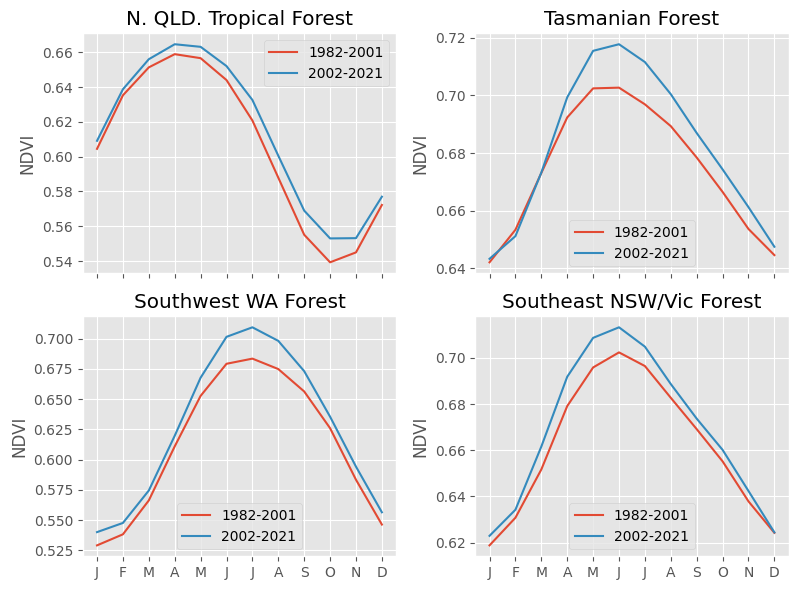

In [10]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2,2, figsize=(8,6), sharex=True)
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    early_clim = v.sel(time=slice('1982', '2000')).groupby('time.month').mean()
    late_clim = v.sel(time=slice('2001', '2021')).groupby('time.month').mean()
    early_clim.mean(['latitude','longitude']).plot(label='1982-2001', ax=ax)
    late_clim.mean(['latitude','longitude']).plot(label='2002-2021', ax=ax)
    ax.set_xlabel(None)
    ax.legend()
    ax.set_title(k)
    ax.set(xticks=range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
plt.tight_layout()    

## Murray Darling Basin

Splitting the MDB into the Northern and Southern Basins.

Excluding 'Trees'

In [11]:
mdb = gpd.read_file('/g/data/os22/chad_tmp/climate-carbon-interactions/data/MDB_catchments.geojson')

nmdb_basins = ['WARREGO RIVER','CONDAMINE-CULGOA RIVERS','PAROO RIVER','DARLING RIVER',
               'MACQUARIE-BOGAN RIVERS','CASTLEREAGH RIVER','NAMOI RIVER','GWYDIR RIVER',
               'BORDER RIVERS','MOONIE RIVER']

nmdb = mdb.loc[mdb['BNAME'].isin(nmdb_basins)]
smdb = mdb.overlay(nmdb, how='difference')

In [12]:
mdb_mask = xr_rasterize(mdb, ds)
nmdb_mask = xr_rasterize(nmdb, ds)
smdb_mask = xr_rasterize(smdb, ds)

mdb_mask = round_coords(mdb_mask)
nmdb_mask = round_coords(nmdb_mask)
smdb_mask = round_coords(smdb_mask)

ds_mdb = ds.where(non_trees_mask).where(mdb_mask, drop=True)
ds_nmdb = ds.where(non_trees_mask).where(nmdb_mask, drop=True)
ds_smdb = ds.where(non_trees_mask).where(smdb_mask, drop=True)

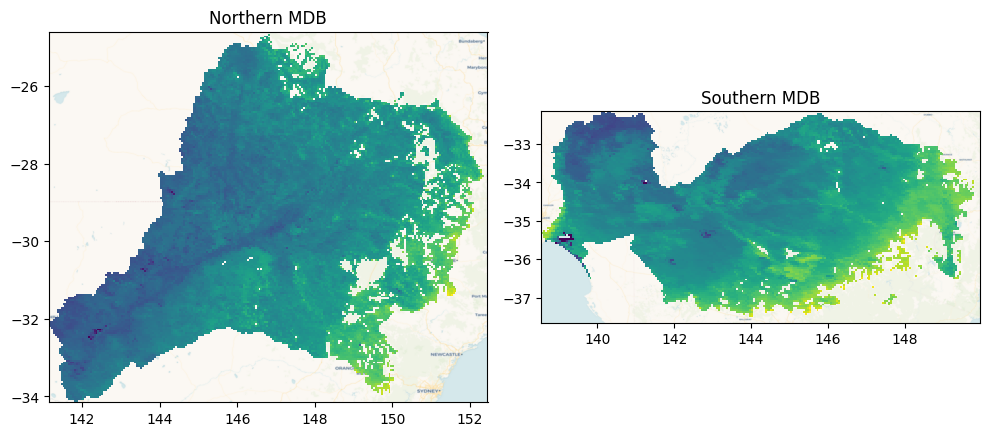

In [13]:
plt.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(10,5))
ds_nmdb.mean('time').plot(ax=ax[0],add_labels=False, vmax=0.7, vmin=0, add_colorbar=False)
ds_smdb.mean('time').plot(ax=ax[1],add_labels=False,vmax=0.7, vmin=0, add_colorbar=False)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_title('Northern MDB')
ax[1].set_title('Southern MDB')
plt.tight_layout();

### Interpolate phenology onto grid

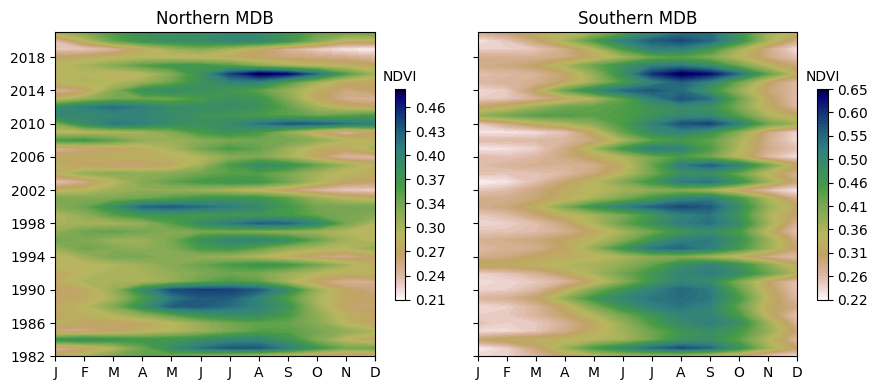

In [14]:
#create a grid
xi = np.linspace(1, 12, 12) #months
yi = np.linspace(1982, 2021, 40) #years
Xi, Yi = np.meshgrid(xi, yi) #grid coords

ds_dict = {'Northern MDB':ds_nmdb,'Southern MDB':ds_smdb}

plt.style.use('default')
fig, axes = plt.subplots(1,2, figsize=(9,4), sharey=True)
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    dss = v.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    zi = griddata(points=(dss.time.dt.month, dss.time.dt.year),
                  values=dss.mean(['latitude','longitude']).values,
                  xi=(xi[None, :], yi[:, None]),
                  method='nearest')
    
    sp = ax.contourf(zi, levels=75, cmap='gist_earth_r')
    clb = plt.colorbar(sp, ax=ax, shrink=0.65, format="%0.2f")
    clb.ax.set_title('NDVI', fontsize=10)
    
    ax.set(xticks=range(0,12))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
    ax.set(yticks=range(0,40))
    ax.set_yticklabels([str(y) for y in range(1982,2022)], fontsize=10);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
    ax.set_title(k);
plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/phenology_grids_MDB.png",
          bbox_inches='tight', dpi=300);

### Interpolate phenology onto grid

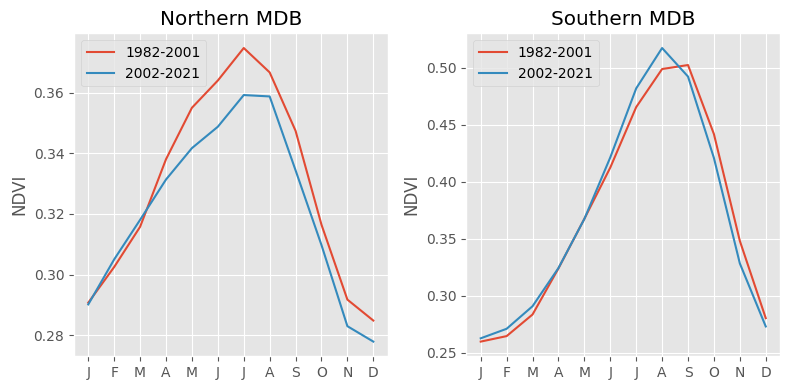

In [15]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1,2, figsize=(8,4))
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    early_clim = v.sel(time=slice('1982', '2000')).groupby('time.month').mean()
    late_clim = v.sel(time=slice('2001', '2021')).groupby('time.month').mean()
    early_clim.mean(['latitude','longitude']).plot(label='1982-2001', ax=ax)
    late_clim.mean(['latitude','longitude']).plot(label='2002-2021', ax=ax)
    ax.set_xlabel(None)
    ax.legend()
    ax.set_title(k)
    ax.set(xticks=range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
plt.tight_layout()    

## Landcovers: Forests vs Agriculture vs Savanna/Tropical Grasslands

### Agricultural areas

Based on GFSAD crop mask

In [16]:
ag = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc').isel(time=0),
                crs='epsg:4326')
ag = xr.where(ag==40,1,0)
ag = ag.odc.reproject(ds.odc.geobox, resampling='mode')
ag = round_coords(ag)
ds_ag = ds.where(non_trees_mask).where(ag)

### Savanna/Tropical Grasses

Following [Donohue 2009](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2008.01746.x)

Extracting maximum grass extent over the MODIS era from within the Savanna & tropical bioclim regions.

Grass is defined as any pixel with > 33 % maximum recurrent fraction

In [17]:
# enter NDVI value of bare soil and maximum NDVI
ndvi_min = 0.141
ndvi_max = 0.91

#calculate f-total
ft = (ds.sel(time=slice('2000','2021')) - ndvi_min) / (ndvi_max - ndvi_min)
ft = xr.where(ft<0, 0, ft)
ft = xr.where(ft>1, 1, ft)

#calculate initial persistent fraction (equation 1 & 2 in Donohue 2009)
persist = ft.rolling(time=7, min_periods=1).min()
persist = persist.rolling(time=9, min_periods=1).mean()

#calculate initial recurrent fraction (equation 3 in Donohue 2009)
recurrent = ft - persist

###------- equations 4 & 5 in Donohue 2009----------------
persist = xr.where(recurrent<0, persist - np.abs(recurrent), persist) #eq4
recurrent = ft - persist # eq 5

#ensure values are between 0 and 1
persist = xr.where(persist<0, 0, persist)
recurrent = xr.where(recurrent<0, 0, recurrent)

#assign variable names
recurrent.name='grass'
recurrent_annual = recurrent.resample(time='1Y').max()

# grass only where there isn't ag and trees.
grass = (recurrent_annual.max('time') >= 0.33)
grass = xr.where(ag==0, grass, 0)
grass = xr.where(trees_mask==0, grass, 0)

# create a savanna mask
bioclim = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
savanna = bioclim.loc[bioclim['region_name'].isin(['Savanna', 'Tropics'])]
savanna = xr_rasterize(savanna, ds)
savanna = round_coords(savanna)

# clip ds to savanna grasses
ds_grass = ds.where(grass).where(savanna)

### Trees

Based on the Woody Cover Fraction product Liao et al. 2020

In [18]:
#make sure water affected pixels are removed along the coasts.
ds_trees = ds_trees.where(ds_trees>0.15)

### Plot landcovers

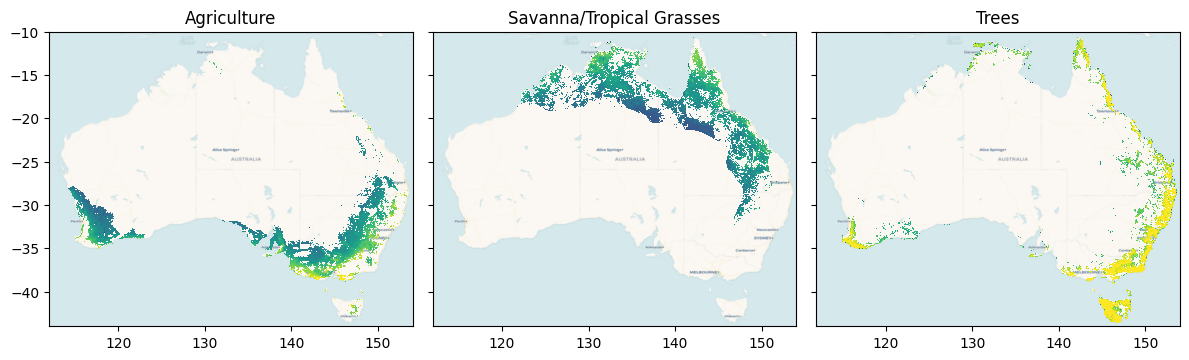

In [19]:
plt.style.use('default')
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
ds_ag.mean('time').plot(ax=ax[0],add_labels=False, vmax=0.7, vmin=0, add_colorbar=False)
ds_grass.mean('time').plot(ax=ax[1],add_labels=False,vmax=0.7, vmin=0, add_colorbar=False)
ds_trees.mean('time').plot(ax=ax[2],add_labels=False,vmax=0.7, vmin=0, add_colorbar=False)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ctx.add_basemap(ax[2], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_title('Agriculture')
ax[1].set_title('Savanna/Tropical Grasses')
ax[2].set_title('Trees')
plt.tight_layout();

### Interpolate phenology onto grid

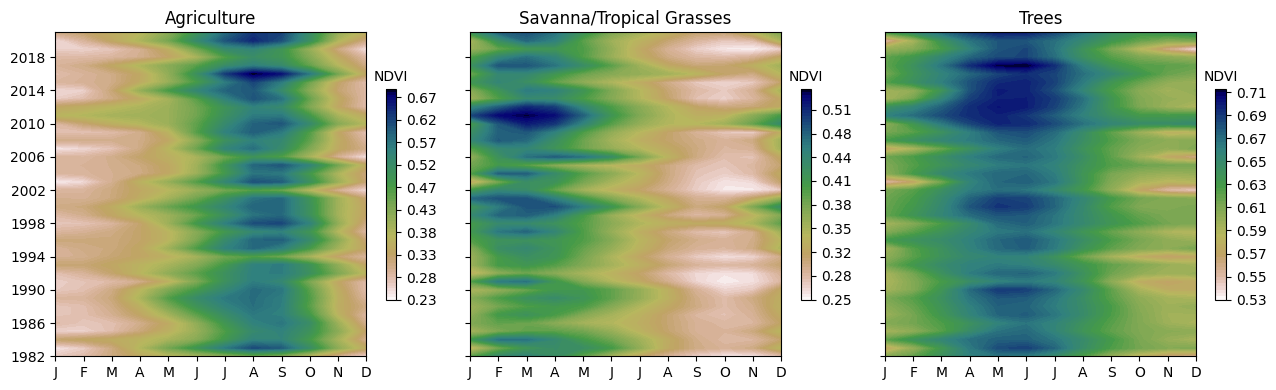

In [20]:
#create a grid
xi = np.linspace(1, 12, 12) #months
yi = np.linspace(1982, 2021, 40) #years
Xi, Yi = np.meshgrid(xi, yi) #grid coords

ds_dict = {'Agriculture':ds_ag,'Savanna/Tropical Grasses':ds_grass, 'Trees':ds_trees}

plt.style.use('default')
fig, axes = plt.subplots(1,3, figsize=(13,4), sharey=True)
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    
    dss = v.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    zi = griddata(points=(dss.time.dt.month, dss.time.dt.year),
                  values=dss.mean(['latitude','longitude']).values,
                  xi=(xi[None, :], yi[:, None]),
                  method='nearest')
    
    sp = ax.contourf(zi, levels=75, cmap='gist_earth_r')
    clb = plt.colorbar(sp, ax=ax, shrink=0.65, format="%0.2f")
    clb.ax.set_title('NDVI', fontsize=10)
    
    ax.set(xticks=range(0,12))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
    ax.set(yticks=range(0,40))
    ax.set_yticklabels([str(y) for y in range(1982,2022)], fontsize=10);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=4))
    ax.set_title(k);
plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/phenology_grids_AgGrassTrees.png",
          bbox_inches='tight', dpi=300);

### Phenology curve early/late

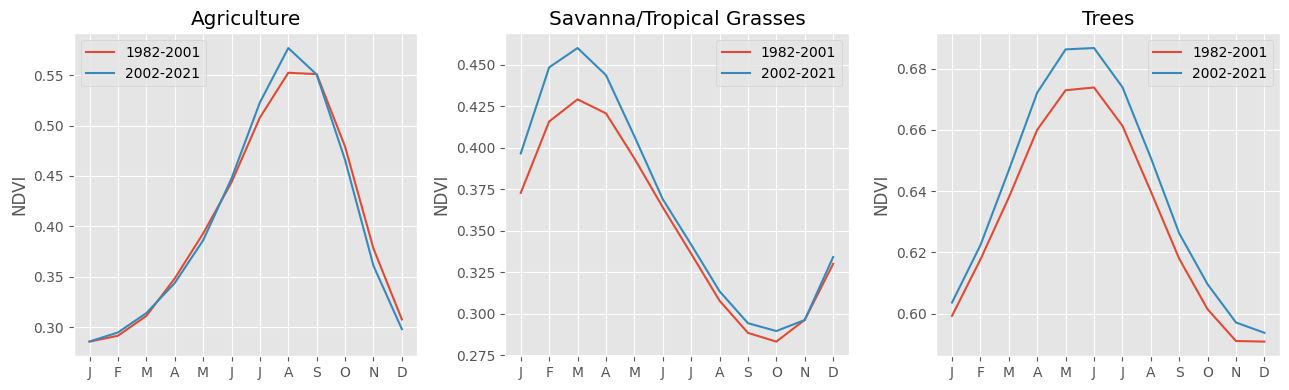

In [21]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1,3, figsize=(13,4))
for ax, (k,v) in zip(axes.reshape(-1), ds_dict.items()):
    early_clim = v.sel(time=slice('1982', '2000')).groupby('time.month').mean()
    late_clim = v.sel(time=slice('2001', '2021')).groupby('time.month').mean()
    early_clim.mean(['latitude','longitude']).plot(label='1982-2001', ax=ax)
    late_clim.mean(['latitude','longitude']).plot(label='2002-2021', ax=ax)
    ax.set_xlabel(None)
    ax.legend()
    ax.set_title(k)
    ax.set(xticks=range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);
plt.tight_layout();